In [1]:
import numpy as np
import math
import cmath
import cPickle
import re
import os as os
import zmq
import time
import copy
import operator
import argparse
import psutil
import warnings
import sys
import os
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import kali
import kali.simulationLC
#import kali.s82
import kali.carma
import kali.util.mcmcviz as mcmcviz
#from kali.util.mpl_settings import set_plot_params
import kali.util.triangle as triangle
import palettable
import richardsplot as rplot
import pickle

In [6]:
jiangSimLC = pickle.load(open('stationaryMHD_KaliObject.pkl', "rb" ))

In [3]:
import kali.simLC_SDSS
jiangSimLC =  kali.simLC_SDSS.csvLC(name='sim0001', path = '/Users/Jackster/Research/code/jiangSim/', downsampled=0,
                             sdssLC = '111332')

Filepath is /Users/Jackster/Research/code/jiangSim/sim0001
The min time lag is 0.057304


In [4]:
jiangSimLC.fit(pMax = 3)

Starting carma fitting for p = 1 and q = 0...
(0.11460726953873746, 0.05730363476936873)
carma took 711.965 s = 11.866 min = 0.198 hrs
C-ARMA(1,0) DIC: -1.474e+05
Starting carma fitting for p = 2 and q = 1...
(0.11460726953873746, 0.05730363476936873)
carma took 1849.538 s = 30.826 min = 0.514 hrs
C-ARMA(2,1) DIC: +1.188e+08
Starting carma fitting for p = 3 and q = 2...
(0.11460726953873746, 0.05730363476936873)
carma took 5164.681 s = 86.078 min = 1.435 hrs
C-ARMA(3,2) DIC: +8.648e+07
Total time taken by carma is 7726.183 s = 128.770 min = 2.146 hrs
Best model is C-ARMA(1,0)


In [64]:

Theta = jiangSimLC.bestTask.Chain[:, np.where(jiangSimLC.bestTask.LnPosterior == np.max(jiangSimLC.bestTask.LnPosterior))[
    0][0], np.where(jiangSimLC.bestTask.LnPosterior == np.max(jiangSimLC.bestTask.LnPosterior))[1][0]]
simulateBestFit = kali.carma.CARMATask(jiangSimLC.pBest, jiangSimLC.qBest)
simulateBestFit.set(jiangSimLC.dt, Theta)

DHO = jiangSimLC.taskDict['%d %d'%(2, 1)]
DHO_Theta = DHO.Chain[:, np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[
    0][0], np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[1][0]]
simulateDHO = kali.carma.CARMATask(2, 1)
simulateDHO.set(jiangSimLC.dt, DHO_Theta)

Order3 = jiangSimLC.taskDict['%d %d'%(3, 2)]
Theta3 = Order3.Chain[:, np.where(Order3.LnPosterior == np.max(Order3.LnPosterior))[
    0][0], np.where(Order3.LnPosterior == np.max(Order3.LnPosterior))[1][0]]
simulateOrder3 = kali.carma.CARMATask(3, 2)
simulateOrder3.set(jiangSimLC.dt,Theta3)
#simulateBestFit.plotpsd(LC = jiangSimLC)

0

In [65]:
DHOroots = DHO.rootChain[:, np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[
    0][0], np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[1][0]]
phi1, phi2 = np.exp(DHOroots[0])+np.exp(DHOroots[1]).real,-np.exp(DHOroots[0]+DHOroots[1]).real
print("DHO ARMA parameters are AR1 = %f AR2 = %f " %(phi1,phi2))
DHOtimescales = DHO.timescaleChain[:, np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[
    0][0], np.where(DHO.LnPosterior == np.max(DHO.LnPosterior))[1][0]]
#print(-1/DHOroots.real[0],-1/DHOroots[1] )
print("The peridoicty of the light curve is %f days and the sampling rate is %f " %(np.sqrt(DHO_Theta[1]),jiangSimLC.dt)
                                                                                  )
print(jiangSimLC.t[78]-jiangSimLC.t[77])
print("the dampening ratio is %f"%( DHO_Theta[0]/(2*np.sqrt(DHO_Theta[1]))))
print("DHO Timescales %s "%str(DHOtimescales))

DHO ARMA parameters are AR1 = 1.825352 AR2 = -0.833501 
The peridoicty of the light curve is 0.094445 days and the sampling rate is 0.097416 
0.0974161791083
the dampening ratio is 0.964167
DHO Timescales [  1.09817283e+01   2.50769111e+02   1.14607277e-01   5.98505273e-03] 


/Users/Jackster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


In [32]:
import pickle
fname = "stationaryMHD_KaliObject"
output = open(fname+'.pkl', 'wb')
pickle.dump(jiangSimLC,output)	
output.close()

# Structure Function

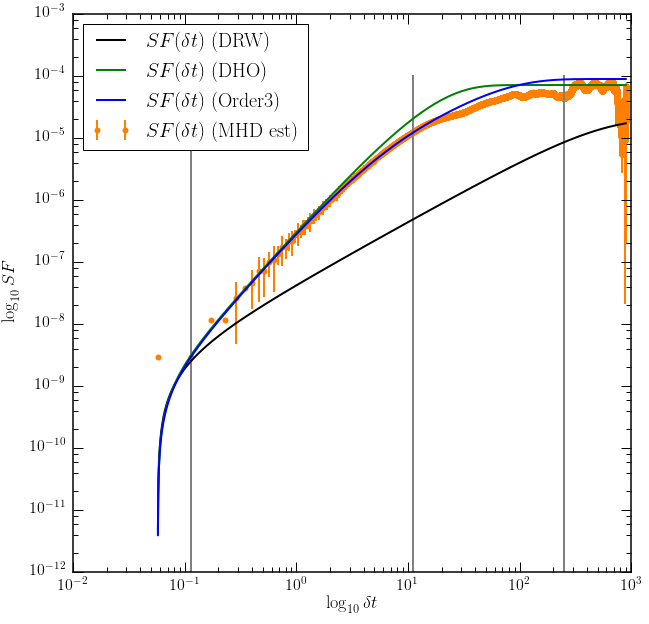

In [66]:
plt.figure(1, figsize=(10, 10))


lagsEst, sfEst, sferrEst = jiangSimLC.sf()
lagsModel, sfModel = simulateBestFit.sf(start=lagsEst[1], stop=lagsEst[-1], num=5000, spacing='log')
lagsDHO, sfDHO = simulateDHO.sf(start=lagsEst[1], stop=lagsEst[-1], num=5000, spacing='log')
lagsOrder3, sfOrder3 = simulateOrder3.sf(start=lagsEst[1], stop=lagsEst[-1], num=5000, spacing='log')

plt.loglog(lagsModel, sfModel, label=r'$SF(\delta t)$ (DRW)', color='#000000', zorder=5)
plt.loglog(lagsDHO, sfDHO, label=r'$SF(\delta t)$ (DHO)', color='green', zorder=5)
plt.loglog(lagsOrder3, sfOrder3, label=r'$SF(\delta t)$ (Order3)', color='blue', zorder=5)
plt.plot([(251), (251)],[10**(-12),10**(-4)], c = 'grey')
plt.plot([(DHOtimescales[0]), (DHOtimescales[0])],[10**(-12),10**(-4)], c = 'grey')
plt.plot([(DHOtimescales[2]), (DHOtimescales[2])],[10**(-12),10**(-4)], c = 'grey')
plt.errorbar(lagsEst, sfEst, sferrEst, label=r'$SF(\delta t)$ (MHD est)',
             fmt='o', capsize=0, color='#ff7f00', markeredgecolor='none', zorder=0)
#errorbars for MHD data are 1% errors ()
plt.xlabel(r'$\log_{10}\delta t$', fontsize = 18)
plt.ylabel(r'$\log_{10} SF$',fontsize = 18 )
plt.legend(loc=2, fontsize = 20)



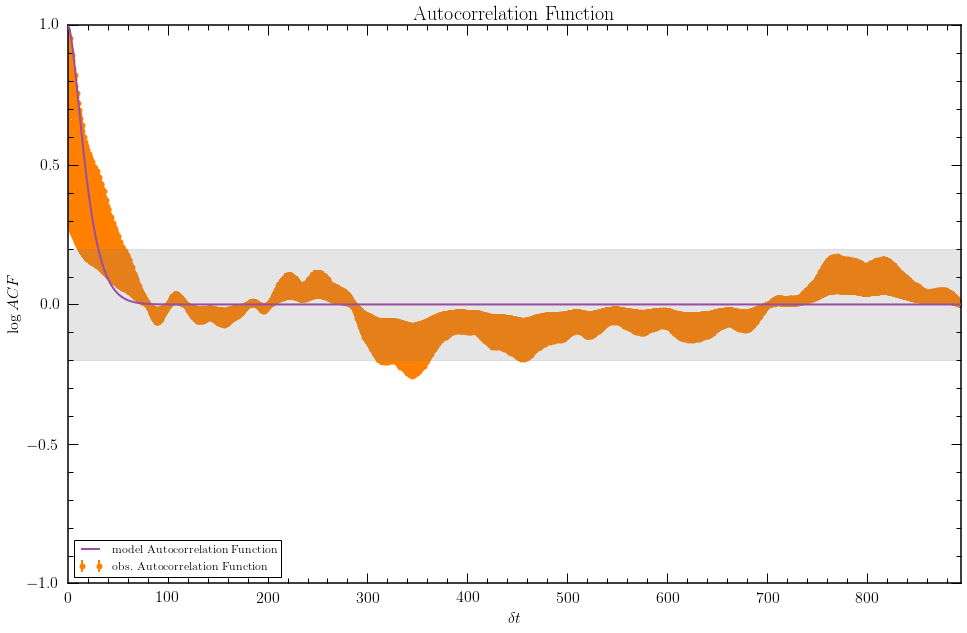

In [52]:

ACF = simulateDHO.plotacf(LC = jiangSimLC, fig =1)
plt.fill_between(np.arange(0,1000, 100), 0.2, -0.2, color = 'grey', alpha = 0.2 )


(array([ -50.,    0.,   50.,  100.,  150.]),
 <a list of 5 Text xticklabel objects>)

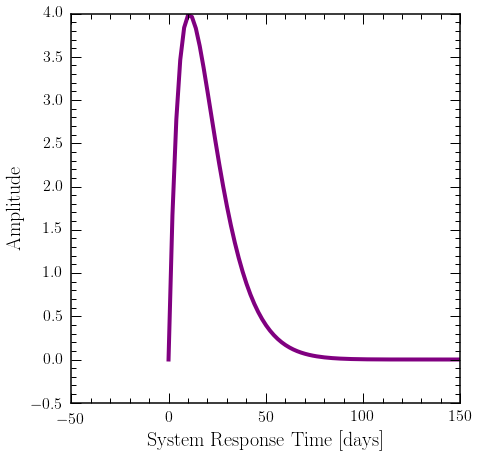

In [28]:
t = np.linspace(0,1000,500)
plt.plot(t, (np.exp(DHOroots[0]*t) -  np.exp(DHOroots[1]*t))/(DHOroots[0]-DHOroots[1]),
         c =  'purple', linewidth = 4)
plt.xlim([-50, 150])

plt.xlabel('System Response Time [days]', fontsize = 20)
plt.ylabel('Amplitude ', fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

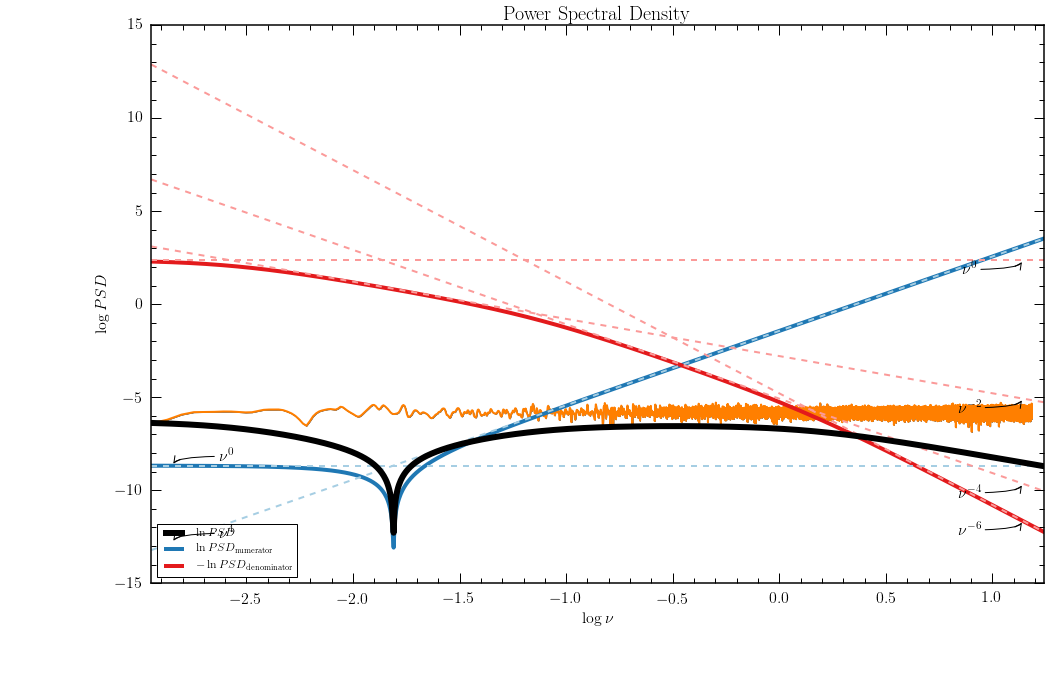

In [67]:
psd3 = simulateOrder3.plotpsd(LC = jiangSimLC)

/Users/Jackster/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


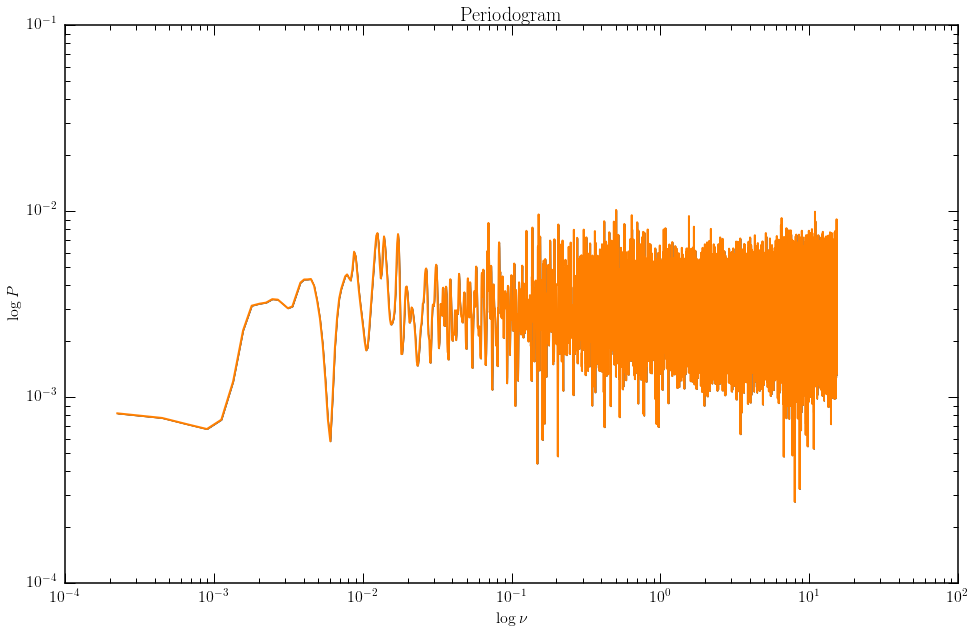

In [13]:
periodogram = jiangSimLC.plotperiodogram()
#periodogram.savefig(figTitle + '_LS_periodogram.png')


In [ ]:
PSDplot = nt.plotpsd(LC = jiangSimLC, doShow = False)
PSDplot.savefig(figTitle+'_PSD.png')

In [ ]:
	a = nt.plotacvf(LC = jiangSimLC)
	a.savefig(figTitle + '_acvf.png')
    
	b = nt
	b.savefig(figTitle + '_acf.png')
	plt.clf()    